In [13]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

## Pre-stress for initial conditions

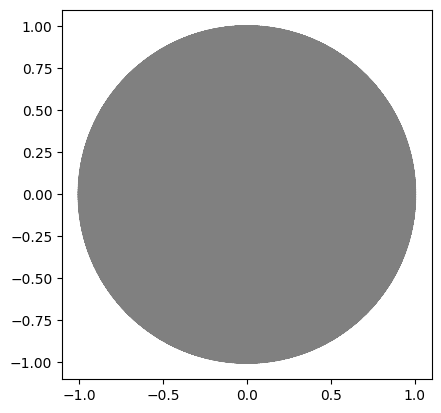

In [14]:
filename = "mesh/meshCircle"
mesh = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh, filename + "_physical_region.xml")
plot(mesh)

In [15]:
# Scaled variables
E = 1e5
nu = 0.3
mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))

# Create mesh and define function space
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol
g = Expression(("0.1*x[0]/sqrt(x[0]*x[0]+x[1]*x[1])", "0.1*x[1]/sqrt(x[0]*x[0]+x[1]*x[1])"), degree=2)
bc = DirichletBC(V, g, bounds,1)

# Define strain and stress

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension() # space dimension
v = TestFunction(V)
f = Constant((0, 0))  # body force
T = Constant((0, 0))
q = 1e4
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
uinit = Function(V)
solve(a == L, uinit, bc)


  Solving linear variational problem.


## Visco-elastic model

In [16]:
# parameters and util functions

E = 1e5
nu = 6*1e7
q = None #3.09*1e5
fy = 4*1e-4
m = 10
Cf = 1e8
T = 20
dt = 0.1
folder_path = "plots/maxwell_test"

def coef(u):
    # print(norm(u))
    return fy*(1-exp(-m*norm(u)))/norm(u) + Cf

def sym_grad(u):
    return 0.5*(grad(u) + grad(u).T)

def antisym_grad(u):
    return 0.5*(grad(u) - grad(u).T)


In [17]:
# Create mesh

filename = "mesh/meshHoles2"
mesh_init = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh_init, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh_init, filename + "_physical_region.xml")

Iteration 0
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Solving linear variational problem.


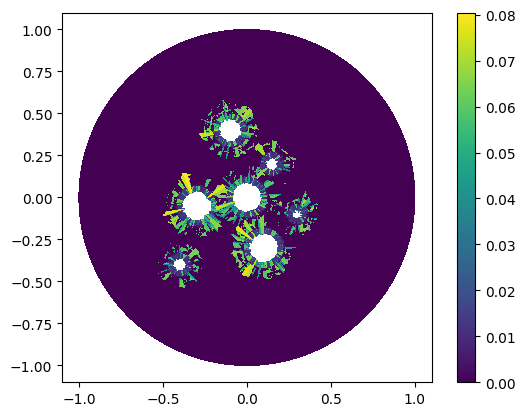

Iteration 1
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Solving linear variational problem.


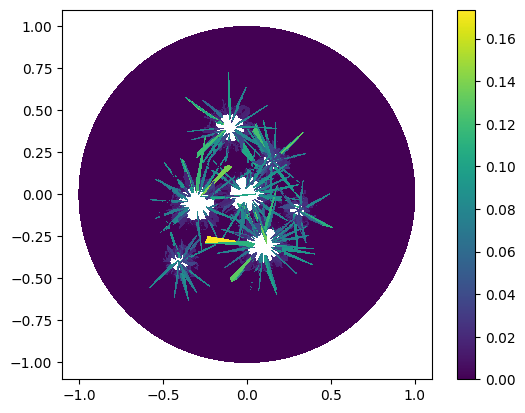

Iteration 2
Calling FFC just-in-time (JIT) compiler, this may take some time.
  Solving linear variational problem.


KeyboardInterrupt: 

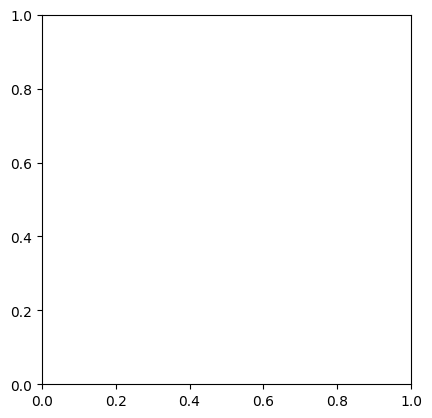

In [18]:
# Create function spaces

V = VectorElement("P", mesh_init.ufl_cell(), 1)
Q = TensorElement("P", mesh_init.ufl_cell(), 1)
W = FunctionSpace(mesh_init,V*Q)

# Define boundary condition

bc_out = DirichletBC(W.sub(0), Constant((0,0)), bounds, 1)
bcs = [bc_out]

# Define variational problem

u0 = interpolate(uinit, W.sub(0).collapse())
sigma0 = project(sigma(u0),W.sub(1).collapse())
# f = Constant((0,0))
for t in range(T):
    print(f'Iteration {t}')
    ut,sigmat = TrialFunctions(W)
    v,w = TestFunctions(W)
    
    a1 = (1/dt)*inner(sigmat,w)*dx + E/nu * inner(sigmat,w)*dx + inner(dot(u0,grad(sigmat)), w)*dx - inner(dot(grad(u0),sigmat),w)*dx \
        - inner(dot(sigmat,grad(u0).T),w)*dx 
        
    L = inner(sym_grad(u0),w)*dx + (1/dt)*inner(sigma0,w)*dx
    a2 = 0.5*inner(sigmat,grad(v))*dx + 0.5*inner(sigmat,grad(v).T)*dx + coef(u0)*inner(ut,v)*dx
    a = a1 + a2
    
    U = Function(W)
    solve(a == L, U, bcs=bcs,solver_parameters={'linear_solver' : 'mumps'})
    u, sigma = U.split()
    if t % 1 == 0:
        sol = plot(u,mode='displacement')
        plt.colorbar(sol)
        # plt.title(f'Displacement at iteration {t}')
        # plt.savefig(f'{folder_path}/displacement_{t}.png')
        plt.show()
        plt.close()
    # mesh update
    # u0.assign(u)
    ALE.move(mesh_init, u)
    V = VectorElement("P", mesh_init.ufl_cell(), 1)
    Q = TensorElement("P", mesh_init.ufl_cell(), 1)
    W = FunctionSpace(mesh_init,V*Q)

    u0 = interpolate(u, W.sub(0).collapse())
    sigma0 = interpolate(sigma, W.sub(1).collapse())
   
    bc_in = DirichletBC(W.sub(0), g, bounds, 4)
    bc_out = DirichletBC(W.sub(0), Constant((0,0)), bounds, 1)
    bcs = [bc_out] #, bc_in]


In [ ]:
import cv2
import os
import re 

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

# Cartella contenente le immagini
images_folder = folder_path

# Elenco delle immagini nella cartella
image_files = [img for img in os.listdir(images_folder) if img.endswith(".jpg") or img.endswith(".png")]

# Ordina le immagini in base al loro nome
image_files.sort(key=extract_number)

# Verifica che ci siano immagini nella cartella
if not image_files:
    print("Non ci sono immagini nella cartella.")
    exit()

# Carica la prima immagine per ottenere le dimensioni del frame
first_image_path = os.path.join(images_folder, image_files[0])
first_image = cv2.imread(first_image_path)

if first_image is None:
    print("Impossibile caricare l'immagine:", first_image_path)
    exit()

frame_height, frame_width, _ = first_image.shape

# Crea un oggetto VideoWriter
output_video_path = f'{folder_path}/video_output.avi'
video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'XVID'), 1, (frame_width, frame_height))

# Itera sulle immagini e scrivile nel video
for image_file in image_files:
    img_path = os.path.join(images_folder, image_file)
    img = cv2.imread(img_path)

    if img is None:
        print("Impossibile caricare l'immagine:", img_path)
        continue

    # Verifica che l'immagine abbia le stesse dimensioni del frame
    if img.shape[1] != frame_width or img.shape[0] != frame_height:
        print("Le dimensioni dell'immagine non corrispondono:", img_path)
        continue

    video.write(img)

# Chiudi il video
video.release()

print(f"Video creato con successo! Salvato come {output_video_path}")

Video creato con successo! Salvato come plots/maxwell_test/video_output.avi


In [ ]:
import json

# Definisci i parametri che vuoi salvare
if q == None:
    parametri = {
        "E": E,
        "nu": nu,
        "fy": fy,
        "m": m,
        "Cf": Cf,
    }
else:
    parametri = {
        "E": E,
        "nu": nu,
        "q": q,
    }

# Nome del file JSON in cui salvare i parametri
nome_file = f'{folder_path}/parametri.json'

# Salva i parametri in un file JSON
with open(nome_file, 'w') as file_json:
    json.dump(parametri, file_json, indent=4)

print(f"Parametri salvati in {nome_file}")


Parametri salvati in plots/maxwell_test/parametri.json
